<a href="https://colab.research.google.com/github/yupopov/stepik-dl-cv/blob/main/module06_mnist_batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional networks for the CIFAR dataset

In this notebook we construct our own convolutional network and train it on the CIFAR dataset. Moreover, we compare its performance with various ResNet's and measure the effects that various regularization techniques (dropout, batch normalization and weight decay) take on the prediction quality.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import random
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Let's load our dataset.

In [ ]:
import torchvision.datasets

In [ ]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [ ]:
len(y_train), len(y_test)

(50000, 10000)

The range of pixel values in our images are from 0 to 255:

In [ ]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

Let's normalize the data and take a look at the images.

In [ ]:
X_train /= 255.
X_test /= 255.

In [ ]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

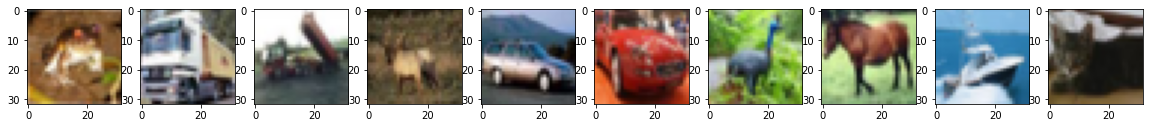

In [ ]:
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [ ]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

We permute the dimensions of our data so that they are PyTorch-compliant (num_images, num_channels, height, width).

In [ ]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [ ]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
X_test = X_test.to(device)
y_test = y_test.to(device)

Below are our functions for training the models and plotting.
In this notebook we choose 256 as the default batch size in order to not have problems with GPU memory.

In [ ]:
def train_network(network, X_train, y_train, X_test, y_test,
                  batch_size=256, n_epochs=20, optimizer=torch.optim.Adam, optimizer_params={},
                  verbose=True, epoch_info_show=10):

    network = network.to(device)

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    loss = nn.CrossEntropyLoss()
    optimizer = optimizer(network.parameters(), **optimizer_params)

    test_accuracy_history = []
    test_loss_history = []
    # train_accuracy_history = []
    # train_loss_history = []

    t = time.time()

    for epoch in range(1, n_epochs+1):
        order = np.random.permutation(len(X_train))
        # train_preds = torch.zeros([X_train.shape[0], 10], dtype=torch.float)
        # train_batch_loss_history = []
        
        network.train()
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            
            batch_indexes = order[start_index:start_index+batch_size]
            
            X_batch = X_train[batch_indexes].to(device) 
            y_batch = y_train[batch_indexes].to(device) 
            
            preds_batch = network.forward(X_batch) 
            
            loss_value = loss(preds_batch, y_batch)
            loss_value.backward()
            
            # train_batch_loss_history.append(loss_value.item())

            # train_preds[batch_indexes] = preds_batch.cpu()

            optimizer.step()

        network.eval()
        with torch.no_grad():
            test_preds = network.forward(X_test)
            test_loss = loss(test_preds, y_test).item()
            test_loss_history.append(test_loss)
            
            test_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(test_accuracy)

            # train_loss = np.mean(train_batch_loss_history)
            # train_loss_history.append(train_loss)
            
            # train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().item()
            # train_accuracy_history.append(train_accuracy)

        if verbose:
            if epoch % epoch_info_show == 0:
                print('Train Epoch: {} Time: {} Val accuracy: {:.4f}, GPU Mem allocated: {} GPU Mem reserved: {}'\
                  .format(epoch, time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), test_accuracy, \
                            torch.cuda.memory_allocated(), torch.cuda.memory_reserved()))

    test_loss_history = np.array(test_loss_history)
    test_accuracy_history = np.array(test_accuracy_history)
    # train_loss_history = np.array(train_loss_history)
    # train_accuracy_history = np.array(train_accuracy_history)

    del network         

    return test_loss_history, test_accuracy_history #, train_loss_history, train_accuracy_history

In [ ]:
accuracies = {}
losses = {}

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15, 6)})

def accuracy_loss_plot(accuracies, losses, net_list):
  fig, (ax1, ax2) = plt.subplots(1, 2)

  for experiment_id in net_list:
      ax1.plot(accuracies[experiment_id], label=experiment_id)
  ax1.legend()
  ax1.set_title('Validation Accuracy')
  fig.tight_layout()

  for experiment_id in net_list:
      ax2.plot(losses[experiment_id], label=experiment_id)
  ax2.legend()
  ax2.set_title('Validation Loss');

  fig.tight_layout()

### *Import ResNet18 from torchvision and compare its performance with CIFARNet.*



Let's begin with the CIFARNet, which was [constructed](https://stepik.org/lesson/230371/step/7?unit=202903) during the course:

In [ ]:
def cifarnet():
  # The initial image tensor is (batch_size, 3, 32, 32)
  cifarnet_module_list = [
    nn.BatchNorm2d(3),
    nn.Conv2d(3, 16, 3, padding=1), # (batch_size, 16, 32, 32)
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2, 2), # (batch_size, 16, 16, 16)
    nn.Conv2d(16, 32, 3, padding=1), # (batch_size, 32, 16, 16)
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2), # (batch_size, 32, 8, 8)
    nn.Conv2d(32, 64, 3, padding=1), # (batch_size, 64, 8, 8)
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Flatten(), # (batch_size, 64 * 8 * 8)
    nn.Linear(8 * 8 * 64, 256),
    nn.Tanh(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 64),
    nn.Tanh(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 10)
  ]

  return nn.Sequential(*cifarnet_module_list)

In this notebook we will only plot the validation losses and accuracies.

Moreover, we run only one experiment for each model (running multiple experiments would be too time-consuming for some networks, especially for ResNet110, and Colab has GPU use limits, you know). If you have your own GPU, run multiple experiments!

In [ ]:
print(f'CIFARNet has {sum(np.array(param.size()).prod() for param in cifarnet().parameters())} parameters')

CIFARNet has 1090384 parameters


In [ ]:
losses['cifarnet'], accuracies['cifarnet'] = \
    train_network(cifarnet(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:00:43 Val accuracy: 0.6881, GPU Mem allocated: 142680576 GPU Mem reserved: 1684013056
Train Epoch: 20 Time: 00:01:25 Val accuracy: 0.6945, GPU Mem allocated: 142680576 GPU Mem reserved: 1684013056
Train Epoch: 30 Time: 00:02:07 Val accuracy: 0.6970, GPU Mem allocated: 142680576 GPU Mem reserved: 1684013056
Train Epoch: 40 Time: 00:02:49 Val accuracy: 0.6920, GPU Mem allocated: 142680576 GPU Mem reserved: 1684013056
Train Epoch: 50 Time: 00:03:31 Val accuracy: 0.7020, GPU Mem allocated: 142680576 GPU Mem reserved: 1684013056


Let's import the ResNet18.

In [ ]:
from torchvision.models import resnet18

The ResNet18 architecture is as follows:
![](https://pytorch.org/assets/images/resnet.png)

This architecture was actually designed for the ImageNet dataset, but is applicable to CIFAR as well, because during the net's run the image size is halved five times, and our image size is exactly 32x32 (the last average pool does nothing in our case).

Moreover, ResNet18 produces a vector of length 1000 (ImageNet has 1000 classes, CIFAR has 10), but it seems that the semantics of [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) allow us to ignore this?? We hope that the network just learns to put zeros in the last 990 places. Finally, the last ResNet18's layer is SoftMax, but the network learns fine with `CrossEntropyLoss`? Weird.

In [ ]:
# The second-to-last layer is a 1000x512 fully-connected one
list(resnet18().parameters())[-2].shape

torch.Size([1000, 512])

In [ ]:
print(f'ResNet18 has {sum(np.array(param.size()).prod() for param in resnet18().parameters())} parameters')

ResNet18 has 11689512 parameters


Let's record Resnet18's accuracies.

In [ ]:
losses['resnet18'], accuracies['resnet18']  = \
    train_network(resnet18(), X_train, y_train, X_test, y_test, n_epochs=30)

Train Epoch: 10 Time: 00:03:17 Val accuracy: 0.6881, GPU Mem allocated: 597962752 GPU Mem reserved: 3030384640
Train Epoch: 20 Time: 00:06:34 Val accuracy: 0.7342, GPU Mem allocated: 597962752 GPU Mem reserved: 3030384640
Train Epoch: 30 Time: 00:09:50 Val accuracy: 0.7372, GPU Mem allocated: 597962752 GPU Mem reserved: 3030384640


Can we do better? Let's load a pretrained model now and change the number of the output neurons to 10.

In [ ]:
our_resnet18 = resnet18(pretrained=True)
our_resnet18.fc = torch.nn.Linear(our_resnet18.fc.in_features, 10)

In [ ]:
losses['resnet18 classes=10'], accuracies['resnet18 classes=10'] = \
    train_network(our_resnet18, X_train, y_train, X_test, y_test, n_epochs=40, epoch_info_show=5)

Train Epoch: 5 Time: 00:01:31 Val accuracy: 0.8002, GPU Mem allocated: 306530816 GPU Mem reserved: 3661627392
Train Epoch: 10 Time: 00:03:02 Val accuracy: 0.8064, GPU Mem allocated: 306530816 GPU Mem reserved: 3661627392
Train Epoch: 15 Time: 00:04:33 Val accuracy: 0.8090, GPU Mem allocated: 306530816 GPU Mem reserved: 3661627392
Train Epoch: 20 Time: 00:06:04 Val accuracy: 0.8118, GPU Mem allocated: 306530816 GPU Mem reserved: 3661627392
Train Epoch: 25 Time: 00:07:34 Val accuracy: 0.7950, GPU Mem allocated: 306530816 GPU Mem reserved: 3661627392
Train Epoch: 30 Time: 00:09:05 Val accuracy: 0.8054, GPU Mem allocated: 306530816 GPU Mem reserved: 3661627392
Train Epoch: 35 Time: 00:10:36 Val accuracy: 0.8130, GPU Mem allocated: 306530816 GPU Mem reserved: 3661627392
Train Epoch: 40 Time: 00:12:07 Val accuracy: 0.8057, GPU Mem allocated: 306530816 GPU Mem reserved: 3661627392


### *Try realizing the ResNet20 yourself. Can you beat ResNet18's quality?*

We take the realization from [here](https://github.com/akamaster/pytorch_resnet_cifar10), introducing the options for enabling/disabling batch normalizations and dropouts.

Let's recall the ResNet architecture.

![](https://miro.medium.com/max/1050/1*chbylvv0Lts1hKEuOJix6g.png)

The first layer of a generic ResNet architecture (for CIFAR) is a 3x3 convolution (with padding equal to 1, so the image size is preserved) with 16 channels.

Each of 3 ResNet's layers in the above image is composed of $n$ `BasicBlock`'s, and each `BasicBlock` is realized as two consecutive 3x3 convolutions (with ReLU as the activation, optionally preceded by batch normalization and dropout) preserving the size of the image and the number of channels plus the identity function (skip connection). A `BasicBlock` for the first level looks like this:

![](https://miro.medium.com/max/888/1*Fyf_jOmNHuHaPAYGJPbDAg.png)

Transitioning between the layers, we double the number of channels and halve the size of the image (applying a convolution with `stride` = 2, so no pooling is used until right before the final fully connected layer). In this case, the skip connection is realized by padding a part of the original tensor with zeros in new channels (see the definition of the `BasicBlock` class).

Finally, we apply an average pooling, obtaining a vector of length 64, and then map it to a vector of the length `num_classes` (10 in our case). More info on ResNet architecture can be found [here](https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0).

In this notebook we consider the ResNet20 (which has $n = 3$ `BasicBlock`'s in each layer, resulting in 1 + 6 + 6 + 6 + 1 = 20 trainable layers and 0.27M parameters) and ResNet110 (having $n = 18$ `BasicBlock`'s in each layer and 1.7M parameters).


In [ ]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A', 
                 use_batch_norm=True, d_out_p=None):
        super(BasicBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.d_out_p = d_out_p
        self.act  = nn.ReLU()
        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # if planes == in_planes, we take stride = 1
        # so that the image size is unchanged
        # if planes == 2*in_planes, we take stride = 2
        # so that the image size is halved
        self.bn1 = nn.BatchNorm2d(planes)
        if self.d_out_p is not None:
            self.d_out1 = nn.Dropout2d(d_out_p)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        # second convolution preserves the image size
        self.bn2 = nn.BatchNorm2d(planes)
        if self.d_out_p is not None:
            self.d_out2 = nn.Dropout2d(d_out_p)

        self.shortcut = nn.Sequential()
        # if planes == in_planes, shortcut is the identity mapping
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                In this case planes = 2*in_planes, and the image size is halved
                so we pad the slice of the original tensor
                with in_planes zero channels from each side in dimension 1
                """
                self.shortcut = LambdaLayer(lambda x: F.pad(x[:, :, ::2, ::2], \
                                            (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
            out = self.bn1(out)
        if self.d_out_p is not None:
            out = self.d_out1(out) 
        out = self.act(out)
        out = self.conv2(out)
        
        if self.use_batch_norm:
            out = self.bn2(out)
        if self.d_out_p is not None:
            out = self.d_out2(out)
          
        out += self.shortcut(x)
        out = self.act(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,
                 use_batch_norm=True, d_out_p=None):
        """
        Parameters:
        num_blocks : list of length 3 —
         list with number of basic blocks in each layer
         (see image above)
        """
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.d_out_p = d_out_p
        self.in_planes = 16
        self.act  = nn.ReLU()

        # The first convolution => (batch_size, 16, 32, 32)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        if self.d_out_p is not None:
            self.d_out1 = nn.Dropout2d(d_out_p)
        # Each layer of convolutions preserves the image tensor dimension
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        # Apply 3x3 convolution to (batch_size, 16, 32, 32) with stride 2
        # and 32 channels => (batch_size, 32, 16, 16)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        # Apply 3x3 convolution to (batch_size, 32, 16, 16) with stride 2
        # and 32 channels => (batch_size, 64, 8, 8)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        # Apply AvgPool by last 2 dimensions = > (batch_size, 64)
        self.linear = nn.Linear(64, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        # The first stride is 2 if we double the number of channels
        # Every other stride in the layer is 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,
                                use_batch_norm=self.use_batch_norm,
                               d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion
            # After doubling the number of channels
            # it stays the same during the whole block

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
            out = self.bn1(out)
        if self.d_out_p is not None:
            out = self.d_out1(out)
          
        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

Here are the ResNets that we will use in this notebook:

In [ ]:
def resnet20(**kwargs):
    return ResNet(BasicBlock, [3, 3, 3], **kwargs)

def resnet44(**kwargs):
    return ResNet(BasicBlock, [7, 7, 7], **kwargs)    

def resnet110(**kwargs):
    return ResNet(BasicBlock, [18, 18, 18], **kwargs)

## Comparing the quality of CIFARNet and ResNet's

Let's train ResNet20 and compare its quality with our CIFARNet and Resnet18.

In [ ]:
print(f'ResNet20 has {sum(np.array(param.size()).prod() for param in resnet20().parameters())} parameters')

ResNet20 has 269722 parameters


In [ ]:
losses['resnet20'], accuracies['resnet20'] = \
    train_network(resnet20(), X_train, y_train, X_test, y_test, n_epochs=20)

Train Epoch: 10 Time: 00:05:48 Val accuracy: 0.7178, GPU Mem allocated: 482389504 GPU Mem reserved: 3672113152
Train Epoch: 20 Time: 00:11:37 Val accuracy: 0.7809, GPU Mem allocated: 482389504 GPU Mem reserved: 3672113152


It is interesting to note that it takes longer to train ResNet20 than ResNet18 despite the latter having around 40 times more parameters. 
We suppose that the training time is highly dependent on the network depth?

Or perhaps it's just our implementation that slows things down.

Let's compare the networks we have trained so far:

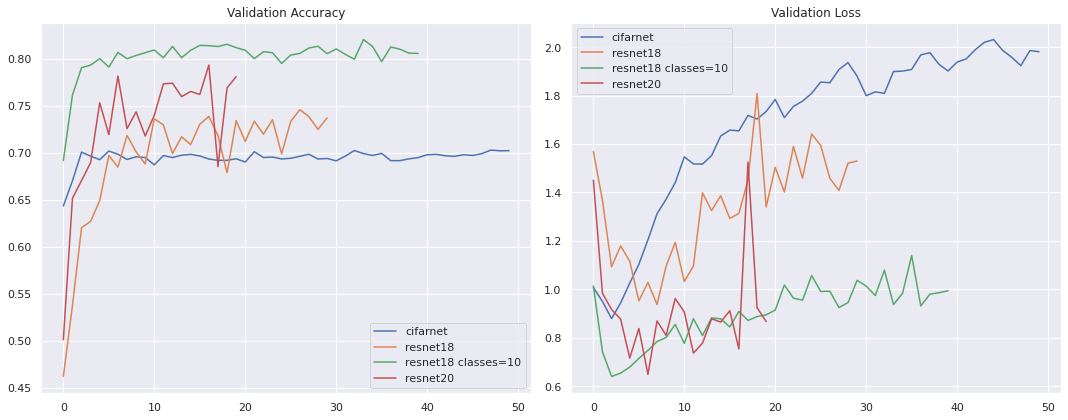

In [ ]:
accuracy_loss_plot(accuracies, losses, ['cifarnet', 'resnet18', 'resnet18 classes=10', 'resnet20',])

Unsurprisingly, ResNets beat our architecture in this task, and ResNet20 (made for CIFAR) beats ResNet18 (built for ImageNet). However, pretrained ResNet18 with 10 outputs instead of 1000 easily beats ResNet20.

We can conclude that adapting a pretrained model (or adopting a known architecture) generally works better that starting from scratch. However, one cannot fiddle with the hyperparameters of the pretrained models, and this will come in handy in the rest of the notebook.

One can see that CIFARNet starts overfitting at the very first epochs: while this isn't visible at the accuracy plot only, the validation loss increases with time (the network becomes more confident in all its answers, including wrong ones).

### *Train ResNet110. Check if it still manages to learn with disabled* `BatchNorm` (you may have to lower the batch size).

To train ResNet110, we have to set batch size to 64.

In [ ]:
losses['resnet110'], accuracies['resnet110'] = \
    train_network(resnet110(), X_train, y_train, X_test, y_test, n_epochs=1, epoch_info_show=1, batch_size=64)

Train Epoch: 1 Time: 00:04:09 Val accuracy: 0.6077, GPU Mem allocated: 198779904 GPU Mem reserved: 3193962496


Yeah... No dice on Colab.

Well, let's train ResNet20 with batch size equal to 64 and disabled batch normalization and see what happens.

In [ ]:
losses['resnet20_no_bn'], accuracies['resnet20_no_bn'] = \
    train_network(resnet20(use_batch_norm=False), X_train, y_train, X_test, y_test, n_epochs=20)

Train Epoch: 10 Time: 00:05:22 Val accuracy: 0.6918, GPU Mem allocated: 149957120 GPU Mem reserved: 3047161856
Train Epoch: 20 Time: 00:10:43 Val accuracy: 0.7677, GPU Mem allocated: 149957120 GPU Mem reserved: 3047161856


In [ ]:
losses['resnet20 bs=64'], accuracies['resnet20 bs=64'] = \
    train_network(resnet20(), X_train, y_train, X_test, y_test, batch_size=64, n_epochs=20)

Train Epoch: 10 Time: 00:07:03 Val accuracy: 0.7765, GPU Mem allocated: 238995968 GPU Mem reserved: 3047161856
Train Epoch: 20 Time: 00:14:07 Val accuracy: 0.7975, GPU Mem allocated: 238995968 GPU Mem reserved: 3047161856


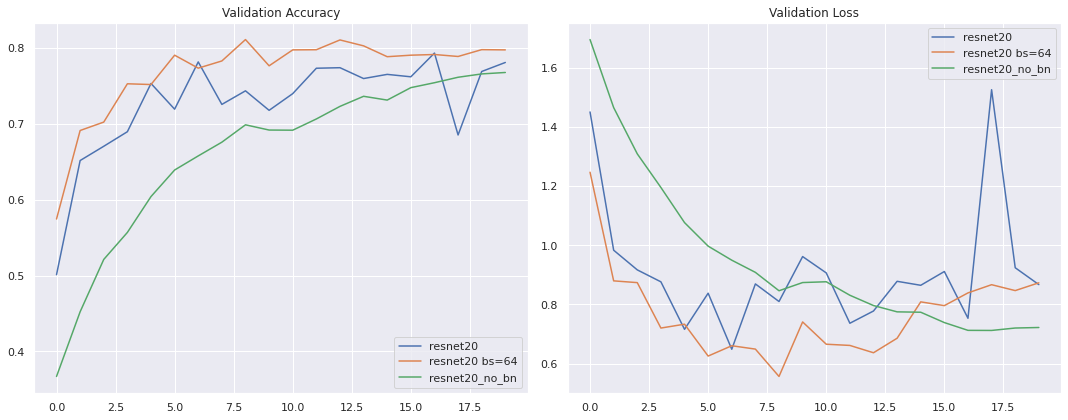

In [ ]:
accuracy_loss_plot(accuracies, losses, ['resnet20','resnet20 bs=64', 'resnet20_no_bn'])

We see that batch normalization speeds up the learning: we need less epochs to achieve higher quality (unfortunately, less epochs to start overfitting as well) and the epochs themselves don't take much longer.

Setting `batch_size=64`, we achieved better results: decreasing batch size increases randomness in the gradient descent and prevents the optimizer from being stuck in local minima.

### *Add* `Dropout2d` *after every* `BatchNorm2d` *in ResNet20. Do you get a positive effect?*

We try dropout probabilites $p = 0.1,\ 0.2,\ 0.4,\ 0.6$.

In [ ]:
losses['resnet20 d_out_p=0.1'], accuracies['resnet20 d_out_p=0.1'] = \
    train_network(resnet20(d_out_p=0.1), X_train, y_train, X_test, y_test, n_epochs=40)

Train Epoch: 10 Time: 00:06:06 Val accuracy: 0.7781, GPU Mem allocated: 163907072 GPU Mem reserved: 3047161856
Train Epoch: 20 Time: 00:12:13 Val accuracy: 0.8264, GPU Mem allocated: 163907072 GPU Mem reserved: 3047161856
Train Epoch: 30 Time: 00:18:19 Val accuracy: 0.8399, GPU Mem allocated: 163907072 GPU Mem reserved: 3047161856
Train Epoch: 40 Time: 00:24:25 Val accuracy: 0.8516, GPU Mem allocated: 163907072 GPU Mem reserved: 3047161856


In [ ]:
losses['resnet20 d_out_p=0.2'], accuracies['resnet20 d_out_p=0.2'] = \
    train_network(resnet20(d_out_p=0.2), X_train, y_train, X_test, y_test, n_epochs=40)

Train Epoch: 10 Time: 00:06:08 Val accuracy: 0.7279, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856
Train Epoch: 20 Time: 00:12:15 Val accuracy: 0.7933, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856
Train Epoch: 30 Time: 00:18:23 Val accuracy: 0.8219, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856
Train Epoch: 40 Time: 00:24:31 Val accuracy: 0.8284, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856


In [ ]:
losses['resnet20 d_out_p=0.4'], accuracies['resnet20 d_out_p=0.4'] = \
    train_network(resnet20(d_out_p=0.4), X_train, y_train, X_test, y_test, n_epochs=20)

Train Epoch: 10 Time: 00:06:07 Val accuracy: 0.5158, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856
Train Epoch: 20 Time: 00:12:15 Val accuracy: 0.6400, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856


In [ ]:
losses['resnet20 d_out_p=0.6'], accuracies['resnet20 d_out_p=0.6'] = \
    train_network(resnet20(d_out_p=0.6), X_train, y_train, X_test, y_test, n_epochs=20)

Train Epoch: 10 Time: 00:06:06 Val accuracy: 0.3435, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856
Train Epoch: 20 Time: 00:12:12 Val accuracy: 0.4026, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856


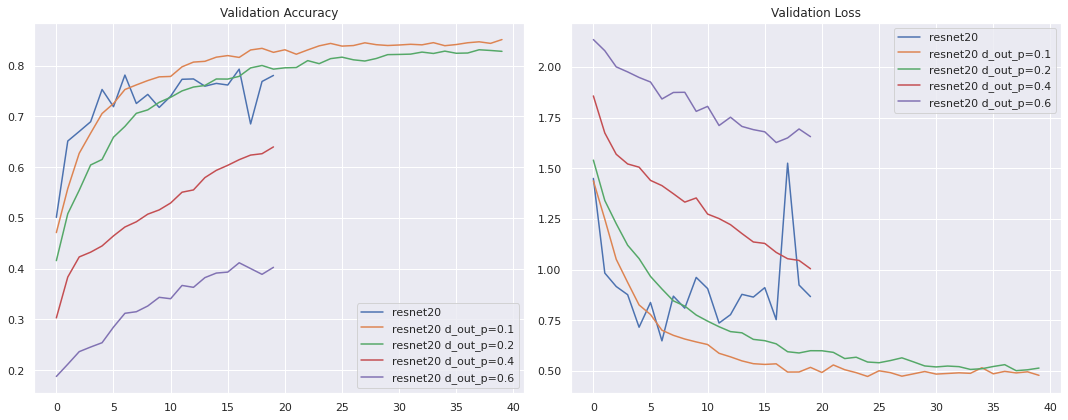

In [ ]:
accuracy_loss_plot(accuracies, losses, ['resnet20', 'resnet20 d_out_p=0.1', 'resnet20 d_out_p=0.2', 'resnet20 d_out_p=0.4', 'resnet20 d_out_p=0.6'])

We see a clear pattern here: the higher the dropout rate, the less overfitting we have (leading to underfitting if it chosen too high). 

At `d_out_p = 0.1` we achieve our highest accuracy so far:

In [ ]:
print(f"{accuracies['resnet20 d_out_p=0.1'].max():.4f}")

0.8516


Note that you have to conduct multiple experiments to check whether this quality isn't simply an outlier!

### Add $L_2$-regularization to the optimizer and see how it affects the learning.

We try regularization coefficients $\lambda = 10^{-i},\ i = 2, 3, 4, 5.$

In [ ]:
optimizer_params = {'weight_decay': 1e-2}
losses['resnet20 wd=1e-2'], accuracies['resnet20 wd=1e-2'] = \
    train_network(resnet20(), X_train, y_train, X_test, y_test, optimizer_params=optimizer_params)

Train Epoch: 10 Time: 00:05:53 Val accuracy: 0.6096, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856
Train Epoch: 20 Time: 00:11:45 Val accuracy: 0.7348, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856


In [ ]:
optimizer_params = {'weight_decay': 1e-3}
losses['resnet20 wd=1e-3'], accuracies['resnet20 wd=1e-3'] = \
    train_network(resnet20(), X_train, y_train, X_test, y_test, optimizer_params=optimizer_params)

Train Epoch: 10 Time: 00:05:53 Val accuracy: 0.6600, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856
Train Epoch: 20 Time: 00:11:46 Val accuracy: 0.7559, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856


In [ ]:
optimizer_params = {'weight_decay': 1e-4}
losses['resnet20 wd=1e-4'], accuracies['resnet20 wd=1e-4'] = \
    train_network(resnet20(), X_train, y_train, X_test, y_test, optimizer_params=optimizer_params)

Train Epoch: 10 Time: 00:05:53 Val accuracy: 0.7278, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856
Train Epoch: 20 Time: 00:11:46 Val accuracy: 0.6898, GPU Mem allocated: 150015488 GPU Mem reserved: 3047161856


In [ ]:
optimizer_params = {'weight_decay': 1e-5}
losses['resnet20 wd=1e-5'], accuracies['resnet20 wd=1e-5'] = \
    train_network(resnet20(), X_train, y_train, X_test, y_test, optimizer_params=optimizer_params)

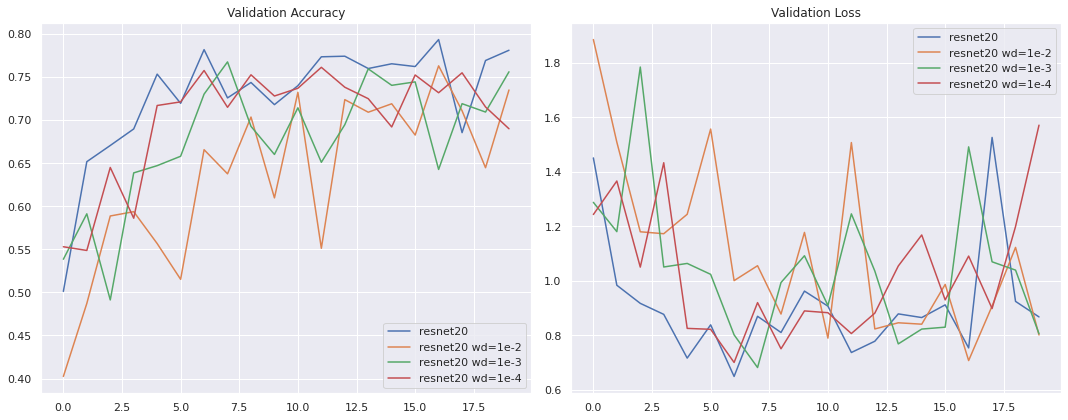

In [ ]:
accuracy_loss_plot(accuracies, losses, ['resnet20', 'resnet20 wd=1e-2', 'resnet20 wd=1e-3','resnet20 wd=1e-4'])

We see no benefits from introducing the $L_2$ regularization in this task, in fact, large weight decay deteriorates the learning.

## **ResNet44**

ResNet110 was too much to handle for Colab, perhaps we can get away with ResNet44?

In [ ]:
losses['resnet44 d_out_p=0.1'], accuracies['resnet44 d_out_p=0.1'] = \
    train_network(resnet44(d_out_p=0.1), X_train, y_train, X_test, y_test, n_epochs=40, epoch_info_show=5)

Train Epoch: 5 Time: 00:06:34 Val accuracy: 0.7480, GPU Mem allocated: 135932928 GPU Mem reserved: 3644850176
Train Epoch: 10 Time: 00:13:07 Val accuracy: 0.8092, GPU Mem allocated: 135932928 GPU Mem reserved: 3644850176
Train Epoch: 15 Time: 00:19:41 Val accuracy: 0.8338, GPU Mem allocated: 135932928 GPU Mem reserved: 3644850176
Train Epoch: 20 Time: 00:26:14 Val accuracy: 0.8418, GPU Mem allocated: 135932928 GPU Mem reserved: 3644850176
Train Epoch: 25 Time: 00:32:47 Val accuracy: 0.8456, GPU Mem allocated: 135932928 GPU Mem reserved: 3644850176
Train Epoch: 30 Time: 00:39:21 Val accuracy: 0.8506, GPU Mem allocated: 135932928 GPU Mem reserved: 3644850176
Train Epoch: 35 Time: 00:45:54 Val accuracy: 0.8506, GPU Mem allocated: 135932928 GPU Mem reserved: 3644850176
Train Epoch: 40 Time: 00:52:27 Val accuracy: 0.8470, GPU Mem allocated: 135932928 GPU Mem reserved: 3644850176


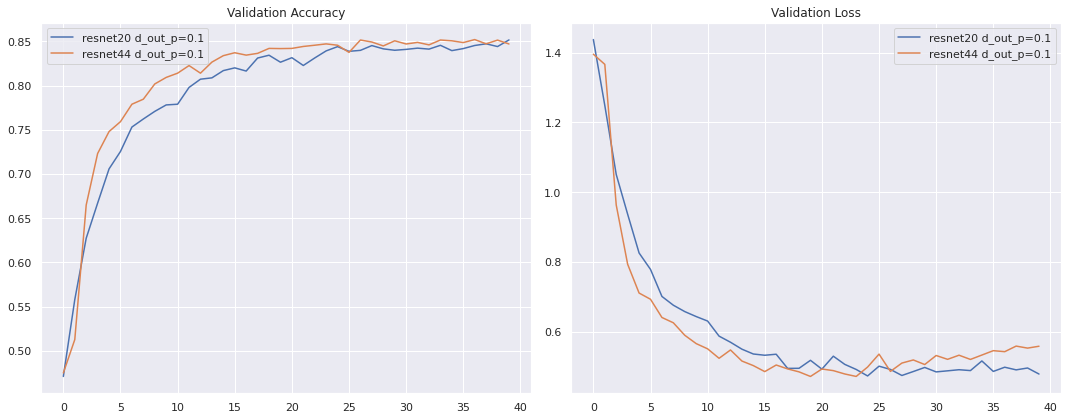

In [ ]:
accuracy_loss_plot(accuracies, losses, ['resnet20 d_out_p=0.1', 'resnet44 d_out_p=0.1'])

We see that ResNet44 outperforms ResNet20, although some fine hyperparameter tuning may be needed as well.

## Conclusion:

We saw that the batch size and dropout rate are important hyperparameters, and a careful tuning of those can improve a neural network's quality (apparently, smaller batch size leads to better results on highly heterogeneous datasets and dropout offers us a tangible control over overfitting and allows a network to learn more patterns).

We also saw that sometimes simply stacking more layers (if you have the computational resources, of course) performs equally well.

![](https://avatars.githubusercontent.com/u/31592135?s=280&v=4)